# Image Colorization with U-Net and GAN Tutorial

**If you have already read the explanations, you can directly go to the code starting with heading: _1 - Implementing the paper - Our Baseline_**

![title image](https://github.com/moein-shariatnia/Deep-Learning/blob/main/Image%20Colorization%20Tutorial/files/main.png?raw=1)

One of the most exciting applications of deep learning is colorizing black and white images.  This task needed a lot of human input and hardcoding several years ago but now the whole process can be done end-to-end with the power of AI and deep learning. You might think that you need huge amount of data or long training times to train your model from scratch for this task but in the last few weeks I worked on this and tried many different model architectures, loss functions, training strategies, etc. and finally developed an efficient strategy to train such a model, using the latest advances in deep learning, on a rather small dataset and with really short training times. In this article, I'm going to explain what I did to make this happen, including the code!, and the strategies that helped and also those that were not useful. Before that, I will explain the colorization problem and a give you a short review of what has been done in recent years. I'll assume you have basic knowledge about deep learning, GANs, and PyTorch library for the rest of the article. Let's begin!

## Introduction to colorization problem

Here I'm going to give you some basic knowledge that you may need to understand what the models do in the following codes.

### RGB vs L\*a\*b

As you might know, when we load an image, we get a rank-3 (height, width, color) array with the last axis containing the color data for our image. These data represent color in RGB color space and there are 3 numbers for each pixel indicating how much Red, Green, and Blue the pixel is. In the following image you can see that in the left part of the "main image" (the leftmost image) we have blue color so in the blue channel of the image, that part has higher values and has turned dark.

![rgb image](https://github.com/moein-shariatnia/Deep-Learning/blob/main/Image%20Colorization%20Tutorial/files/rgb.jpg?raw=1)

In L\*a\*b color space, we have again three numbers for each pixel but these numbers have different meanings. The first number (channel), L, encodes the Lightness of each pixel and when we visualize this channel (the second image in the row below) it appears as a black and white image. The \*a and \*b channels encode how much green-red and yellow-blue each pixel is, respectively. In the following image you can see each channel of L\*a\*b color space separately.

![lab image](https://github.com/moein-shariatnia/Deep-Learning/blob/main/Image%20Colorization%20Tutorial/files/lab.jpg?raw=1)

In all papers I studied and all codes I checked out on colorization on GitHub, people use L\*a\*b color space instead of RGB to train the models. There are a couple of reasons for this choice but I'll give you an intuition of why we make this choice. To train a model for colorization, we should give it a grayscale image and hope that it will make it colorful. When using L\*a\*b, we can give the L channel to the model (which is the grayscale image) and want it to predict the other two channels (\*a, \*b) and after its prediction, we concatenate all the channels and we get our colorful image. But if you use RGB, you have to first convert your image to grayscale, feed the grayscale image to the model and hope it will predict 3 numbers for you which is a way more difficult and unstable task due to the many more possible combinations of 3 numbers compared to two numbers. If we assume we have 256 choices (in a 8-bit unsigned integer image this is the real number of choices) for each number, predicting the three numbers for each of the pixels is choosing between 256³ combinations which is more than 16 million choices, but when predicting two numbers we have about 65000 choices (actually, we are not going to wildly choose these numbers like a classification task and I just wrote these numbers to give you an intuition).

## How to solve the problem

During the last few years, many different solutions have been proposed to colorize images by using deep learning. [_**Colorful Image Colorization**_](https://arxiv.org/abs/1603.08511) paper approached the problem as a classification task and they also considered the uncertainty of this problem (e.x. a car in the image can take on many different and valid colors and we cannot be sure about any color for it); however, another paper approached the problem as a regression task (with some more tweaks!). There are pros and cons to each approach but in this article, we are going to use a different strategy.

### The strategy we are going to use

[_**Image-to-Image Translation with Conditional Adversarial Networks**_](https://arxiv.org/abs/1611.07004) paper, which you may know by the name pix2pix, proposed a general solution to many image-to-image tasks in deep learning which one of those was colorization. In this approach two losses are used: L1 loss, which makes it a regression task, and an adversarial (GAN) loss, which helps to solve the problem in an unsupervised manner (by assigning the outputs a number indicating how "real" they look!).

In this tutorial, I will first implement what the authors did in the paper and then I will introduce a whole new generator model and some tweaks in the strategy of training which significantly helps reduce the size of needed dataset while getting amazing results. So stay tuned :)

### A deeper dive into GAN world

As mentioned earlier, we are going to build a GAN (a conditional GAN to be specific) and use an extra loss function, L1 loss. Let's start with the GAN.

As you might know, in a GAN we have a generator and a discriminator model which learn to solve a problem together. In our setting, the generator model takes a grayscale image (1-channel image) and produces a 2-channel image, a channel for \*a and another for \*b. The discriminator, takes these two produced channels and concatenates them with the input grayscale image and decides whether this new 3-channel image is fake or real. Of course the discriminator also needs to see some real images (3-channel images again in Lab color space) that are not produced by the generator and should learn that they are real.

So what about the "condition" we mentioned? Well, that grayscale image which both the generator and discriminator see is the condition that we provide to both models in our GAN and expect that the they take this condition into consideration.

Let's take a look at the math. Consider _**x**_ as the grayscale image, _**z**_ as the input noise for the generator, and _**y**_ as the 2-channel output we want from the generator (it can also represent the 2 color channels of a real image). Also, _**G**_ is the generator model and _**D**_ is the discriminator. Then the loss for our conditional GAN will be:

![GAN Loss](https://github.com/moein-shariatnia/Deep-Learning/blob/main/Image%20Colorization%20Tutorial/files/GAN_loss.jpg?raw=1)

Notice that _**x**_ is given to both models which is the condition we introduce two both players of this game. Actually, we are not going to feed a "n" dimensional vector of random noise to the generator as you might expect but the noise is introduced in the form of dropout layers (there is something cool about it which you will read in the last section of the article) in the generator architecture.

### Loss function we optimize

The earlier loss function helps to produce good-looking colorful images that seem real, but to further help the models and introduce some supervision in our task, we combine this loss function with L1 Loss (you might know L1 loss as mean absolute error) of the predicted colors compared with the actual colors:

![L1 loss](https://github.com/moein-shariatnia/Deep-Learning/blob/main/Image%20Colorization%20Tutorial/files/l1_loss.jpg?raw=1)

If we use L1 loss alone, the model still learns to colorize the images but it will be conservative and most of the time uses colors like "gray" or "brown" because when it doubts which color is the best, it takes the average and uses these colors to reduce the L1 loss as much as possible (it is similar to the blurring effect of L1 or L2 loss in super resolution task). Also, the L1 Loss is preferred over L2 loss (or mean squared error) because it reduces that effect of producing gray-ish images. So, our combined loss function will be:

![loss](https://github.com/moein-shariatnia/Deep-Learning/blob/main/Image%20Colorization%20Tutorial/files/loss.jpg?raw=1)

where _**λ**_ is a coefficient to balance the contribution of the two losses to the final loss (of course the discriminator loss does not involve the L1 loss).

Okay. I think it's enough for theory! Let's get our hands dirty with the code! In the following section, **I first introduce the code to implement the paper** and in the section after that, **I will introduce a better strategy to get really amazing results in one or two hours of training and without needing huge amount of data!**

## 1 - Implementing the paper - Our Baseline

### 1.1- Loading Image Paths

The paper uses the whole ImageNet dataset (with 1.3 million images!) but here I'm using only 8,000 images from COCO dataset for training which I had available on my device. So our training set size is 0.6% of what was used in the paper!
You can use almost any dataset for this task as far as it contains many different scenes and locations which you hope it will learn to colorize. You can use ImageNet for example but you will only need 8000 of its images for this project.

In [20]:
import os
import glob
import time
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb

import torch
from torch import nn, optim
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_colab = None

### 1.1.x Preparing Colab for running the code

If you are opening this on **Google Colab** you can uncomment and run the following to install fastai. Almost all of the code in the tutorial is with **pure PyTorch**. We need fastai here only to download part of COCO dataset and in one other step in the second section of the tutorial.

Also make sure to set your runtime to **GPU** to be able to train the models much faster.

In [21]:
!pip install fastai==2.4

  Using cached fastai-2.4-py3-none-any.whl (187 kB)
  Using cached fastcore-1.3.29-py3-none-any.whl (55 kB)
INFO: pip is looking at multiple versions of fastai to determine which version is compatible with other requirements. This could take a while.
ERROR: Could not find a version that satisfies the requirement torch<1.10,>=1.7.0 (from fastai) (from versions: 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 2.0.0, 2.0.1, 2.1.0)
ERROR: No matching distribution found for torch<1.10,>=1.7.0


The following will download about 20,000 images from COCO dataset. Notice that **we are going to use only 8000 of them** for training. Also you can use any other dataset like ImageNet as long as it contains various scenes and locations.

In [22]:
from fastai.data.external import untar_data, URLs
coco_path = untar_data(URLs.COCO_SAMPLE)
coco_path = str(coco_path) + "/train_sample"
use_colab = True

In [23]:
if use_colab == True:
    path = coco_path
else:
    path = "Your path to the dataset"

paths = glob.glob(path + "/*.jpg") # Grabbing all the image file names
np.random.seed(123)
paths_subset = np.random.choice(paths, 10_000, replace=False) # choosing 1000 images randomly
rand_idxs = np.random.permutation(10_000)
train_idxs = rand_idxs[:8000] # choosing the first 8000 as training set
val_idxs = rand_idxs[8000:] # choosing last 2000 as validation set
train_paths = paths_subset[train_idxs]
val_paths = paths_subset[val_idxs]
print(len(train_paths), len(val_paths))

8000 2000


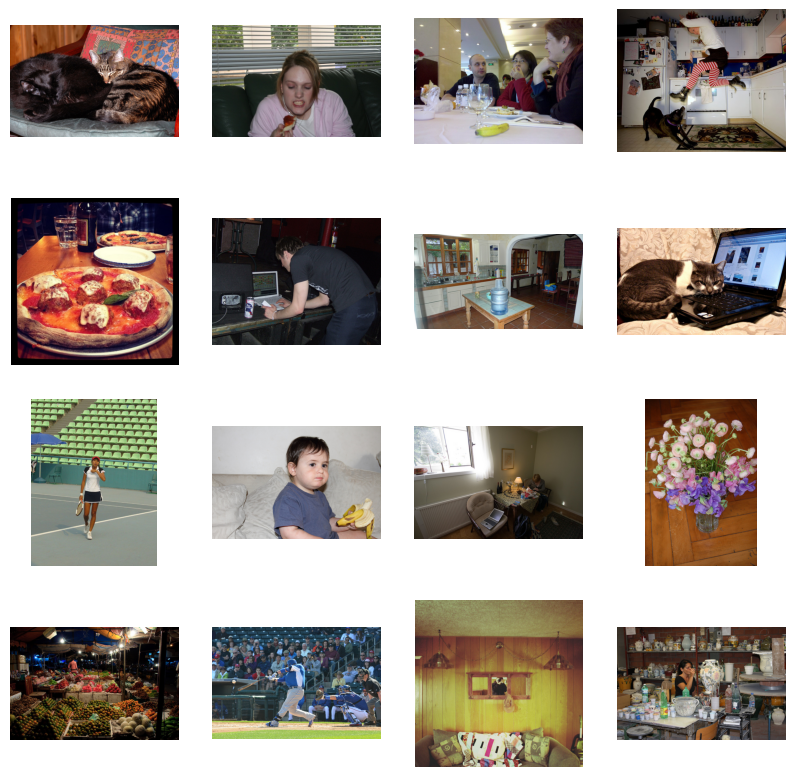

In [24]:
_, axes = plt.subplots(4, 4, figsize=(10, 10))
for ax, img_path in zip(axes.flatten(), train_paths):
    ax.imshow(Image.open(img_path))
    ax.axis("off")

Although we are using the same dataset and number of training samples, the exact 8000 images that you train your model on may vary (although we are seeding!) because the dataset here has only 20000 images with different ordering while I sampled 10000 images from the complete dataset.

### 1.2- Making Datasets and DataLoaders

I hope the code is self-explanatory. I'm resizing the images and flipping horizontally (flipping only if it is training set) and then I read an RGB image, convert it to Lab color space and separate the first (grayscale) channel and the color channels as my inputs and targets for the models  respectively. Then I'm making the data loaders.

In [25]:
SIZE = 256
class ColorizationDataset(Dataset):
    def __init__(self, paths, split='train'):
        if split == 'train':
            self.transforms = transforms.Compose([
                transforms.Resize((SIZE, SIZE),  Image.BICUBIC),
                transforms.RandomHorizontalFlip(), # A little data augmentation!
            ])
        elif split == 'val':
            self.transforms = transforms.Resize((SIZE, SIZE),  Image.BICUBIC)

        self.split = split
        self.size = SIZE
        self.paths = paths

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        img = self.transforms(img)
        img = np.array(img)
        img_lab = rgb2lab(img).astype("float32") # Converting RGB to L*a*b
        img_lab = transforms.ToTensor()(img_lab)
        L = img_lab[[0], ...] / 50. - 1. # Between -1 and 1
        ab = img_lab[[1, 2], ...] / 110. # Between -1 and 1

        return {'L': L, 'ab': ab}

    def __len__(self):
        return len(self.paths)

def make_dataloaders(batch_size=16, n_workers=4, pin_memory=True, **kwargs): # A handy function to make our dataloaders
    dataset = ColorizationDataset(**kwargs)
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=n_workers,
                            pin_memory=pin_memory)
    return dataloader

In [26]:
train_dl = make_dataloaders(paths=train_paths, split='train')
val_dl = make_dataloaders(paths=val_paths, split='val')

data = next(iter(train_dl))
Ls, abs_ = data['L'], data['ab']
print(Ls.shape, abs_.shape)
print(len(train_dl), len(val_dl))

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


torch.Size([16, 1, 256, 256]) torch.Size([16, 2, 256, 256])
500 125


### 1.3- Generator proposed by the paper

This one is a little complicated and needs explanation. This code implements a U-Net to be used as the generator of our GAN. The details of the code are out of the scope of this article but the important thing to understand is that it makes the U-Net from the middle part of it (down in the U shape) and adds down-sampling and up-sampling modules to the left and right of that middle module (respectively) at every iteration until it reaches the input module and output module. Look at the following image that I made from one of the images in the article to give you a better sense of what is happening in the code:

![unet](https://github.com/moein-shariatnia/Deep-Learning/blob/main/Image%20Colorization%20Tutorial/files/unet.png?raw=1)

The blue rectangles show the order in which the related modules are built with the code. The U-Net we will build has more layers than what is depicted in this image but it suffices to give you the idea. Also notice in the code that we are going 8 layers down, so if we start with a 256 by 256 image, in the middle of the U-Net we will get a 1 by 1 (256 / 2⁸) image and then it gets up-sampled to produce a  256 by 256 image (with two channels). This code snippet is really exciting and I highly recommend to play with it to fully grasp what every line of it is doing.

In [38]:
class DownUnetLayer(nn.Module):
    def __init__(self, nf, ni, submodule=None, input_c=None, dropout=False,
                 innermost=False, outermost=False, second_innermost=False):
        super().__init__()
        self.outermost = outermost
        self.innermost = innermost
        self.second_innermost = second_innermost
        self.innermost_val = None
        if input_c is None: input_c = nf
        downconv = nn.Conv2d(input_c, ni, kernel_size=4,
                             stride=2, padding=1, bias=False)
        downrelu = nn.LeakyReLU(0.2, False)
        downnorm = nn.BatchNorm2d(ni)
        uprelu = nn.ReLU(False)
        upnorm = nn.BatchNorm2d(nf)

        if outermost:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down
        elif innermost:
            upconv = nn.ConvTranspose2d(ni, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]
            if dropout: up += [nn.Dropout(0.5)]
            model = down
        self.model = nn.Sequential(*model)


    def get_innermost_val(self):
        return self.innermost_val

    def set_inner_search(self, inner_search=True):
        self.inner_search = inner_search

    def forward(self, x):
        if self.innermost:

            innermost_val = self.model(x)
            print("val--------------")
            print(innermost_val.shape)

        else:
            print("normal")

        # if self.outermost:
        #     return self.model(x)
        # else:
        #     return torch.cat([x, self.model(x)], 1)
        return self.model(x)





class UpUnetLayer(nn.Module):
    def __init__(self, nf, ni, submodule=None, input_c=None, dropout=False,
                 innermost=False, outermost=False, second_innermost=False):
        super().__init__()
        self.outermost = outermost
        self.innermost = innermost
        self.second_innermost = second_innermost
        self.innermost_val = None
        if input_c is None: input_c = nf
        downconv = nn.Conv2d(input_c, ni, kernel_size=4,
                             stride=2, padding=1, bias=False)
        downrelu = nn.LeakyReLU(0.2, False)
        downnorm = nn.BatchNorm2d(ni)
        uprelu = nn.ReLU(False)
        upnorm = nn.BatchNorm2d(nf)

        if outermost:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = up
        elif innermost:
            upconv = nn.ConvTranspose2d(ni, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]
            if dropout: up += [nn.Dropout(0.5)]
            model = up
        self.model = nn.Sequential(*model)

    def get_innermost_val(self):
        return self.innermost_val

    def set_inner_search(self, inner_search=True):
        self.inner_search = inner_search

    def forward(self, x, x_block):
        if self.innermost:

            innermost_val = self.model(x)
            print("val--------------")
            print(innermost_val.shape)

        else:
            print("normal")

        # if self.outermost:
        #     return self.model(x)
        # else:
        #     return torch.cat([x, self.model(x)], 1)
        x = torch.cat([x_block, x], 1)
        return self.model(x)


class InnermostUnetLayer(nn.Module):
    def __init__(self, nf, ni, submodule=None, input_c=None, dropout=False,
                 innermost=False, outermost=False, second_innermost=False):
        super().__init__()
        self.outermost = outermost
        self.innermost = innermost
        self.second_innermost = second_innermost
        self.innermost_val = None
        if input_c is None: input_c = nf
        downconv = nn.Conv2d(input_c, ni, kernel_size=4,
                             stride=2, padding=1, bias=False)
        downrelu = nn.LeakyReLU(0.2, False)
        downnorm = nn.BatchNorm2d(ni)
        uprelu = nn.ReLU(False)
        upnorm = nn.BatchNorm2d(nf)

        upconv = nn.ConvTranspose2d(ni, nf, kernel_size=4,
                                    stride=2, padding=1, bias=False)
        down = [downrelu, downconv]
        up = [uprelu, upconv, upnorm]
        model = down + up

        self.model = nn.Sequential(*model)

    def get_innermost_val(self):
        return self.innermost_val

    def set_inner_search(self, inner_search=True):
        self.inner_search = inner_search

    def forward(self, x, x_block):
        if self.innermost:

            innermost_val = self.model(x)
            print("val--------------")
            print(innermost_val.shape)

        else:
            print("normal")

        # if self.outermost:
        #     return self.model(x)
        # else:
        #     return torch.cat([x, self.model(x)], 1)
        return self.model(x)













class UnetBlock(nn.Module):
    def __init__(self, nf, ni, submodule=None, input_c=None, dropout=False,
                 innermost=False, outermost=False, second_innermost=False):
        super().__init__()
        self.outermost = outermost
        self.innermost = innermost
        self.second_innermost = second_innermost
        self.innermost_val = None
        if input_c is None: input_c = nf
        downconv = nn.Conv2d(input_c, ni, kernel_size=4,
                             stride=2, padding=1, bias=False)
        downrelu = nn.LeakyReLU(0.2, False)
        downnorm = nn.BatchNorm2d(ni)
        uprelu = nn.ReLU(False)
        upnorm = nn.BatchNorm2d(nf)

        if outermost:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(ni, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]
            if dropout: up += [nn.Dropout(0.5)]
            model = down + [submodule] + up
        self.model = nn.Sequential(*model)
        if innermost:
          def hook_fn(module, input, output):
            print("Saving middle layer output to global variable")
            global middle_layer_output
            middle_layer_output = output

          self.model.register_forward_hook(hook_fn)



    def get_innermost_val(self):
        return self.innermost_val

    def set_inner_search(self, inner_search=True):
        self.inner_search = inner_search

    def forward(self, x):
        if self.innermost:

            innermost_val = self.model(x)
            print("val--------------")
            print(innermost_val.shape)

        else:
            print("normal")

        if self.outermost:
            return self.model(x)
        else:
            return torch.cat([x, self.model(x)], 1)

class ClassifierModel(nn.Module):
  def __init__(self, input_size=512*4, output_size=5):
        super().__init__()
        self.fc = nn.Linear(input_size, output_size)

  def forward(self, x):
      return self.fc(x)

class MLTModel(nn.Module):
    def __init__(self, input_c=1, output_c=2, n_down=8, num_filters=64):
        super().__init__()
        unet_block = UnetBlock(num_filters * 8, num_filters * 8, innermost=True)
        for _ in range(n_down - 5):
            unet_block = UnetBlock(num_filters * 8, num_filters * 8, submodule=unet_block, dropout=True)
        out_filters = num_filters * 8
        for _ in range(3):
            unet_block = UnetBlock(out_filters // 2, out_filters, submodule=unet_block)
            out_filters //= 2
        self.u_model = UnetBlock(output_c, out_filters, input_c=input_c, submodule=unet_block, outermost=True)
        self.classifier = ClassifierModel()
    def forward(self, x):
        x_u = self.u_model(x)
        # self.u_model.set_inner_search(True)
        # innermost_val = self.u_model(x)
        print("innermost_val:")
        print(middle_layer_output.shape)
        x_c = self.classifier(middle_layer_output.view(-1, 512*2*2))
        # return torch.cat([x_u, x_c], 1)
        return x_u, x_c

class MLTModelV2(nn.Module):
    def __init__(self, input_c=1, output_c=2, n_down=8, num_filters=64):
        super().__init__()
        self.up_layers = []
        self.down_layers = []
        self.down_hidden_val = []
        self.innermost_layer = InnermostUnetLayer(num_filters * 8, num_filters * 8, innermost=True)
        for _ in range(n_down - 5):
            self.up_layers.append(UpUnetLayer(num_filters * 8, num_filters * 8, dropout=True))
            self.down_layers.append(DownUnetLayer(num_filters * 8, num_filters * 8, dropout=True))
        out_filters = num_filters * 8
        for _ in range(3):
            self.up_layers.append(UpUnetLayer(out_filters // 2, out_filters))
            self.down_layers.append(DownUnetLayer(out_filters // 2, out_filters))
            out_filters //= 2
        self.up_layers.append(UpUnetLayer(output_c, out_filters, input_c=input_c, outermost=True))
        self.down_layers.append(DownUnetLayer(output_c, out_filters, input_c=input_c, outermost=True))
        self.classifier = ClassifierModel()
    def forward(self, x):
        self.down_hidden_val = []
        for down_layer in self.down_layers:
            x = down_layer(x)
            self.down_hidden_val.append(x)
        self.down_hidden_val = self.down_hidden_val.reverse()

        x = self.innermost_layer(x)
        middle_layer_output = x

        for i, up_layer in enumerate(self.up_layers):
            x = up_layer(x, self.down_hidden_val[i])
        x_u = x

        x_c = self.classifier(middle_layer_output.view(-1, 512*2*2))
        # return torch.cat([x_u, x_c], 1)
        return x_u, x_c
class TestBlock(nn.Module):
    def __init__(self):
        super().__init__()

### 1.4- Discriminator

The architecture of our discriminator is rather straight forward. This code implements a model by stacking blocks of Conv-BatchNorm-LeackyReLU to decide whether the input image is fake or real. Notice that the first and last blocks do not use normalization and the last block has no activation function (it is embedded in the loss function we will use).

In [28]:
class PatchDiscriminator(nn.Module):
    def __init__(self, input_c, num_filters=64, n_down=3):
        super().__init__()
        model = [self.get_layers(input_c, num_filters, norm=False)]
        model += [self.get_layers(num_filters * 2 ** i, num_filters * 2 ** (i + 1), s=1 if i == (n_down-1) else 2)
                          for i in range(n_down)] # the 'if' statement is taking care of not using
                                                  # stride of 2 for the last block in this loop
        model += [self.get_layers(num_filters * 2 ** n_down, 1, s=1, norm=False, act=False)] # Make sure to not use normalization or
                                                                                             # activation for the last layer of the model
        self.model = nn.Sequential(*model)

    def get_layers(self, ni, nf, k=4, s=2, p=1, norm=True, act=True): # when needing to make some repeatitive blocks of layers,
        layers = [nn.Conv2d(ni, nf, k, s, p, bias=not norm)]          # it's always helpful to make a separate method for that purpose
        if norm: layers += [nn.BatchNorm2d(nf)]
        if act: layers += [nn.LeakyReLU(0.2, True)]
        return nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

Let's take a look at its blocks:

In [29]:
PatchDiscriminator(3)

PatchDiscriminator(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (

And its output shape:

In [30]:
discriminator = PatchDiscriminator(3)
dummy_input = torch.randn(16, 3, 256, 256) # batch_size, channels, size, size
out = discriminator(dummy_input)
out.shape

torch.Size([16, 1, 30, 30])

We are using a "Patch" Discriminator here. Okay, what is it?! In a vanilla discriminator, the model outputs one number (a scaler) which represents how much the model thinks the input (which is the whole image) is real (or fake). In a patch discriminator, the model outputs one number for every patch of say 70 by 70 pixels of the input image and for each of them decides whether it is fake or not separately. Using such a model for the task of colorization seems reasonable to me because the local changes that the model needs to make are really important and maybe deciding on the whole image as in vanilla discriminator cannot take care of the subtleties of this task. Here, the model's output shape is 30 by 30 but it does not mean that our patches are 30 by 30. The actual patch size is obtained when you compute the receptive field of each of these 900 (30 multiplied by 30) output numbers which in our case will be 70 by 70.

### 1.5- GAN Loss

This is a handy class we can use to calculate the GAN loss of our final model. In the __init__ we decide which kind of loss we're going to use (which will be "vanilla" in our project) and register some constant tensors as the "real" and "fake" labels. Then when we call this module, it makes an appropriate tensor full of zeros or ones (according to what we need at the stage) and computes the loss.

In [31]:
class GANLoss(nn.Module):
    def __init__(self, gan_mode='vanilla', real_label=1.0, fake_label=0.0):
        super().__init__()
        self.register_buffer('real_label', torch.tensor(real_label))
        self.register_buffer('fake_label', torch.tensor(fake_label))
        if gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode == 'lsgan':
            self.loss = nn.MSELoss()

    def get_labels(self, preds, target_is_real):
        if target_is_real:
            labels = self.real_label
        else:
            labels = self.fake_label
        return labels.expand_as(preds)

    def __call__(self, preds, target_is_real):
        labels = self.get_labels(preds, target_is_real)
        loss = self.loss(preds, labels)
        return loss

### 1.x Model Initialization

In the TowardsDataScince article, I didn't explain this function. Here is our logic to initialize our models. We are going to initialize the weights of our model with a mean of 0.0 and standard deviation of 0.02 which are the proposed hyperparameters in the article:

In [32]:
def init_weights(net, init='norm', gain=0.02):

    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and 'Conv' in classname:
            if init == 'norm':
                nn.init.normal_(m.weight.data, mean=0.0, std=gain)
            elif init == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=gain)
            elif init == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')

            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif 'BatchNorm2d' in classname:
            nn.init.normal_(m.weight.data, 1., gain)
            nn.init.constant_(m.bias.data, 0.)

    net.apply(init_func)
    print(f"model initialized with {init} initialization")
    return net

def init_model(model, device):
    model = model.to(device)
    model = init_weights(model)
    return model

### 1.6- Putting everything together

This class brings together all the previous parts and implements a few methods to take care of training our complete model. Let's investigate it.

In the __init__ we define our generator and discriminator using the previous functions and classes we defined and we also initialize them with init_model function which I didn't explain here but you can refer to my GitHub repository to see how it works. Then we define our two loss functions and the optimizers of the generator and discriminator.

The whole work is being done in optimize method of this class. First and only once per iteration (batch of training set) we call the module's forward method and store the outputs in fake_color variable of the class.

Then, we first train the discriminator by using backward_D method in which we feed the fake images produced by generator to the discriminator (make sure to detach them from the generator's graph so that they act as a constant to the discriminator, like normal images) and label them as fake. Then we feed a batch of real images from training set to the discriminator and label them as real. We add up the two losses for fake and real and take the average and then call the backward on the final loss.
Now, we can train the generator. In backward_G method we feed the discriminator the fake image and try to fool it by assigning real labels to them and calculating the adversarial loss. As I mentioned earlier, we use L1 loss as well and compute the distance between the predicted two channels and the target two channels and multiply this loss by a coefficient (which is 100 in our case) to balance the two losses and then add this loss to the adversarial loss. Then we call the backward method of the loss.

In [33]:
class MainModel(nn.Module):
    def __init__(self, net_G=None, lr_G=2e-4, lr_D=2e-4,
                 beta1=0.5, beta2=0.999, lambda_L1=100.):
        super().__init__()

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lambda_L1 = lambda_L1

        if net_G is None:
            self.net_G = init_model(MLTModelV2(input_c=1, output_c=2, n_down=8, num_filters=64), self.device)
            print(self.net_G.parameters())
        else:
            self.net_G = net_G.to(self.device)
        self.net_D = init_model(PatchDiscriminator(input_c=3, n_down=3, num_filters=64), self.device)
        self.GANcriterion = GANLoss(gan_mode='vanilla').to(self.device)
        self.L1criterion = nn.L1Loss()
        self.class_criterion = nn.CrossEntropyLoss()
        self.opt_G = optim.Adam(self.net_G.parameters(), lr=lr_G, betas=(beta1, beta2))
        self.opt_D = optim.Adam(self.net_D.parameters(), lr=lr_D, betas=(beta1, beta2))

    def set_requires_grad(self, model, requires_grad=True):
        for p in model.parameters():
            p.requires_grad = requires_grad

    def setup_input(self, data):
        self.L = data['L'].to(self.device)
        self.ab = data['ab'].to(self.device)

    def forward(self):
        g_out = self.net_G(self.L)
        self.fake_color = g_out[0]
        self.class_pred = g_out[1]
        print(f"Class preds: {torch.argmax(self.class_pred, dim=1)}")

    def backward_D(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image.detach())
        self.loss_D_fake = self.GANcriterion(fake_preds, False)
        real_image = torch.cat([self.L, self.ab], dim=1)
        real_preds = self.net_D(real_image)
        self.loss_D_real = self.GANcriterion(real_preds, True)
        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5
        self.loss_D.backward()

    def backward_G(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image)
        self.loss_G_GAN = self.GANcriterion(fake_preds, True)
        self.loss_G_L1 = self.L1criterion(self.fake_color, self.ab) * self.lambda_L1

        # Loss for classifier
        dummy_labels = a = torch.zeros(16, 5)
        dummy_labels[:, 2] = 1
        dummy_labels[0, 2] = 0
        dummy_labels[0, 3] = 1
        # dummy_labels[3, 2] = 0
        # dummy_labels[6, 2] = 0
        # dummy_labels[10, 2] = 0
        # dummy_labels[3, 4] = 1
        # dummy_labels[6, 3] = 1
        # dummy_labels[10, 3] = 1
        self.class_loss = self.class_criterion(self.class_pred, dummy_labels.to(self.device))
        self.loss_G = self.loss_G_GAN + self.loss_G_L1 + self.class_loss
        self.loss_G.backward()

    def optimize(self):
        self.forward()
        self.net_D.train()
        self.set_requires_grad(self.net_D, True)
        self.opt_D.zero_grad()
        self.backward_D()
        self.opt_D.step()

        self.net_G.train()
        self.set_requires_grad(self.net_D, False)
        self.opt_G.zero_grad()
        self.backward_G()
        self.opt_G.step()

### 1.xx Utility functions

These functions were nor included in the explanations of the TDS article. These are just some utility functions to log the losses of our network and also visualize the results during training. So here you can check them out:

In [34]:
class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.count, self.avg, self.sum = [0.] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += count * val
        self.avg = self.sum / self.count

def create_loss_meters():
    loss_D_fake = AverageMeter()
    loss_D_real = AverageMeter()
    loss_D = AverageMeter()
    loss_G_GAN = AverageMeter()
    loss_G_L1 = AverageMeter()
    loss_G = AverageMeter()

    return {'loss_D_fake': loss_D_fake,
            'loss_D_real': loss_D_real,
            'loss_D': loss_D,
            'loss_G_GAN': loss_G_GAN,
            'loss_G_L1': loss_G_L1,
            'loss_G': loss_G}

def update_losses(model, loss_meter_dict, count):
    for loss_name, loss_meter in loss_meter_dict.items():
        loss = getattr(model, loss_name)
        loss_meter.update(loss.item(), count=count)

def lab_to_rgb(L, ab):
    """
    Takes a batch of images
    """

    L = (L + 1.) * 50.
    ab = ab * 110.
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)

def visualize(model, data, save=True):
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    model.net_G.train()
    fake_color = model.fake_color.detach()
    real_color = model.ab
    L = model.L
    fake_imgs = lab_to_rgb(L, fake_color)
    real_imgs = lab_to_rgb(L, real_color)
    fig = plt.figure(figsize=(15, 8))
    for i in range(5):
        ax = plt.subplot(3, 5, i + 1)
        ax.imshow(L[i][0].cpu(), cmap='gray')
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 5)
        ax.imshow(fake_imgs[i])
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 10)
        ax.imshow(real_imgs[i])
        ax.axis("off")
    plt.show()
    if save:
        fig.savefig(f"colorization_{time.time()}.png")

def log_results(loss_meter_dict):
    for loss_name, loss_meter in loss_meter_dict.items():
        print(f"{loss_name}: {loss_meter.avg:.5f}")

### 1.7- Training function

I hope this code is self-explanatory. Every epoch takes about 4 minutes on not a powerful GPU as Nvidia P5000. So if you are using 1080Ti or higher, it will be much faster.

In [39]:
def train_model(model, train_dl, epochs, display_every=200):
    data = next(iter(val_dl)) # getting a batch for visualizing the model output after fixed intrvals
    for e in range(epochs):
        loss_meter_dict = create_loss_meters() # function returing a dictionary of objects to
        i = 0                                  # log the losses of the complete network
        for data in tqdm(train_dl):
            model.setup_input(data)
            model.optimize()
            update_losses(model, loss_meter_dict, count=data['L'].size(0)) # function updating the log objects
            i += 1
            if i % display_every == 0:
                print(f"\nEpoch {e+1}/{epochs}")
                print(f"Iteration {i}/{len(train_dl)}")
                log_results(loss_meter_dict) # function to print out the losses
                visualize(model, data, save=False) # function displaying the model's outputs

model = MainModel()

train_model(model, train_dl, 3)

model initialized with norm initialization
<generator object Module.parameters at 0x7dcc8cedd150>
model initialized with norm initialization


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/500 [00:00<?, ?it/s]

normal


RuntimeError: ignored

Every epoch takes about 3 to 4 minutes on Colab. After about 20 epochs you should see some reasonable results.

Okay. I let the model train for some longer (about 100 epochs). Here are the results of our baseline model:

![baseline](https://github.com/moein-shariatnia/Deep-Learning/blob/main/Image%20Colorization%20Tutorial/files/baseline.png?raw=1)

As you can see, although this baseline model has some basic understanding of some most common objects in images like sky, trees, … its output is far from something appealing and it cannot decide on the color of rare objects. It also displays some color spillovers and circle-shaped mass of color (center of first image of second row) which is not good at all. So, it seems like that with this small dataset we cannot get good results with this strategy. **Therefore, we change our strategy!**

## 2- A new strategy - the final model

Here is the focus of this article and where I'm going to explain what I did to overcome the last mentioned problem. Inspired by an idea in Super Resolution literature, I decided to pretrain the generator separately in a supervised and deterministic manner to avoid the problem of "the blind leading the blind" in the GAN game where neither generator nor discriminator knows anything about the task at the beginning of training.

Actually I use pretraining in two stages: 1- The backbone of the generator (the down sampling path) is a pretrained model for classification (on ImageNet) 2- The whole generator will be pretrained on the task of colorization with L1 loss.

In fact, I'm going to use a pretrained ResNet18 as the backbone of my U-Net and to accomplish the second stage of pretraining, we are going to train the U-Net on our training set with only L1 Loss. Then we will move to the combined adversarial and L1 loss, as we did in the previous section.

### 2.1- Using a new generator

Building a U-Net with a ResNet backbone is not something trivial so I'll use fastai library's Dynamic U-Net module to easily build one. You can simply install fastai with pip or conda (if you haven't already at the beginning of the tutorial). Here's the link to the [documentation](https://docs.fast.ai/).

#### Update Jan 8th, 2022: <br>
You need to install fastai version 2.4 for the following lines code to run w/o errors.
If you have already installed it using the cell in the beginning of the tutorial, you don't need to install it here again.
<br><br><br>

In [ ]:
# pip install fastai==2.4
from fastai.vision.learner import create_body
from torchvision.models.resnet import resnet18
from fastai.vision.models.unet import DynamicUnet

In [ ]:
def build_res_unet(n_input=1, n_output=2, size=256):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    body = create_body(resnet18, pretrained=True, n_in=n_input, cut=-2)
    net_G = DynamicUnet(body, n_output, (size, size)).to(device)
    return net_G

That's it! With just these few lines of code you can build such a complex model easily. create_body function loads the pretrained weights of the ResNet18 architecture and cuts the model to remove the last two layers (GlobalAveragePooling and a Linear layer for the ImageNet classification task). Then, DynamicUnet uses this backbone to build a U-Net with the needed output channels (2 in our case) and with an input size of 256.

### 2.2 Pretraining the generator for colorization task

In [ ]:
def pretrain_generator(net_G, train_dl, opt, criterion, epochs):
    for e in range(epochs):
        loss_meter = AverageMeter()
        for data in tqdm(train_dl):
            L, ab = data['L'].to(device), data['ab'].to(device)
            preds = net_G(L)
            loss = criterion(preds, ab)
            opt.zero_grad()
            loss.backward()
            opt.step()

            loss_meter.update(loss.item(), L.size(0))

        print(f"Epoch {e + 1}/{epochs}")
        print(f"L1 Loss: {loss_meter.avg:.5f}")

net_G = build_res_unet(n_input=1, n_output=2, size=256)
opt = optim.Adam(net_G.parameters(), lr=1e-4)
criterion = nn.L1Loss()
pretrain_generator(net_G, train_dl, opt, criterion, 20)
#torch.save(net_G.state_dict(), "res18-unet.pt")

With this simple function, we pretrain the generator for 20 epochs and then we save its weights. This will take an hour on Colab. In the following section, we will use this model as the generator for our GAN and train the whole network as before:

### 2.3 Putting everything together, again!

If you want to train the model yourself, run the following cell. Instead, if you want to use the pretrained weights, skip the cell and run the one after that.

In [ ]:
net_G = build_res_unet(n_input=1, n_output=2, size=256)
net_G.load_state_dict(torch.load("res18-unet.pt", map_location=device))
model = MainModel(net_G=net_G)
train_model(model, train_dl, 20)

Here I'm first loading the saved weights for the generator (which you have saved in the previous section) and then I'm using this model as the generator in our MainModel class  which prevents it from randomly initializing the generator. Then we train the model for 10 to 20 epochs! (compare it to the 100 epochs of the previous section when we didn't use pretraining). Each epoch takes about 3 to 4 minutes on Colab

If you are on Colab and want to use the pretrained weights, run the following cells which download the weights from my google drive and loads it to the model:

In [ ]:
# !gdown --id 1lR6DcS4m5InSbZ5y59zkH2mHt_4RQ2KV

In [ ]:
# net_G = build_res_unet(n_input=1, n_output=2, size=256)
# net_G.load_state_dict(torch.load("res18-unet.pt", map_location=device))
# model = MainModel(net_G=net_G)
# model.load_state_dict(torch.load("final_model_weights.pt", map_location=device))

Now, I will show the results of this final model on the test set (the black and white images that it has never seen during training) including the main title image of this article at the very beginning:

![output 1](https://github.com/moein-shariatnia/Deep-Learning/blob/main/Image%20Colorization%20Tutorial/files/main.png?raw=1)
Left: Input black & white images from test set | Right: the colorized outputs by the final model of this tutorial
---
![output2](https://github.com/moein-shariatnia/Deep-Learning/blob/main/Image%20Colorization%20Tutorial/files/img1.png?raw=1)
Left: Input black & white images from test set | Right: the colorized outputs by the final model of this tutorial
---
![output3](https://github.com/moein-shariatnia/Deep-Learning/blob/main/Image%20Colorization%20Tutorial/files/img2.png?raw=1)
Left: Input black & white images from test set | Right: the colorized outputs by the final model of this tutorial
---

## An accidental finding: You can safely remove Dropout!

Remember that when I was explaining the theory of conditional GAN in the beginning of this article, I said that the source of the noise in the architecture of the generator proposed by authors of the paper was the dropout layers. However, when I investigated the U-Net we built with the help of fastai, I did not find any dropout layers in there! Actually I first trained the final model and got the results and then I investigated the generator and found this out.

So, was the adversarial training useless? If there is no noise, how possibly the generator can have a creative effect on the output? Is it possible that the input grayscale image to the generator plays the role of noise as well? These were my exact questions at the time.

Therefor, I decided to email Dr. Phillip Isola, the first author of the same paper we implemented here, and he kindly answered these questions. According to what he said,  this conditional GAN can still work without dropout but the outputs will be more deterministic because of the lack of that noise; however, there is still enough information in that input grayscale image which enables the generator to produce compelling outputs.
Actually, I saw this in practice that the adversarial training was helpful indeed. In the next and last section, I'm going to compare the results of the pretrained U-Net with no adversarial training against the final outputs we got with adversarial training.

## Comparing the results of the pretrained U-Net with and without adversarial training

One of the cool thing I found in my experiments was that the U-Net we built with the ResNet18 backbone is already awesome in colorizing images after pretraining with L1 Loss only (a step before the final adversarial training). But, the model is still conservative and encourages using gray-ish colors when it is not sure about what the object is or what color it should be. However, it performs really awesome for common scenes in the images like sky, tree, grass, etc.

Here I show you the outputs of the U-Net without adversarial training and U-Net with adversarial training to better depict the significant difference that the adversarial training is making in our case:

![comparison](https://github.com/moein-shariatnia/Deep-Learning/blob/main/Image%20Colorization%20Tutorial/files/comparison1.png?raw=1)
(Left: pretrained U-Net without adversarial training | Right: pretrained U-Net with adversarial training)
---

You can also see the GIF below to observe the difference between the images better:

![anim](https://github.com/moein-shariatnia/Deep-Learning/blob/main/Image%20Colorization%20Tutorial/files/anim_compare.gif?raw=1)
(animation of the last two images to better see the significant difference that adversarial training is making)
---

## Final words

This project was full of important lessons for myself. I spent a lot of time during the last month to implement lots of different papers each with different strategies and it took quite a while and after A LOT of failures that I could come up with this method of training. Now you can see that how pretraining the generator significantly helped the model and improved the results.

I also learned that some observations, although at first feeling like a bad mistake of yours, are worth paying attention to and further investigation; like the case of dropout in this project. Thanks to the helpful community of deep learning and AI, you can easily ask experts and get the answer you need and become more confidant in what you were just guessing.

I want to thank the authors of this wonderful paper for their awesome work and also [the great GitHub repository of this paper](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix) from which I borrowed some of the codes (with modification and simplification). I truly love the community of computer science and AI and all their hard work to improve the field and also make their contributions available to all. I'm happy to be a tiny part of this community.